## Identificación de colonias con características similares

En este notebook se identificarán colonias con características similares a San Carlos Cantera, la cual se encuentra en el municipio de Ecatepec, Estado de México.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import requests
import zipfile
import folium
import matplotlib.pyplot as plt
from conda.common.url import maybe_unquote
from sklearn.cluster import KMeans
import numpy as np

In [9]:
os.makedirs("data", exist_ok=True)
#Función para descargar y extraer información de archivos zip
os.chdir("C:/Users/claud/Documents/Github/proyecto_simi")

In [10]:
#Función para descargar y extraer información de archivos zip

def download_and_extract(url, filename, check_file_path, extract_path):
    # Checar si el archivo ya existe
    if os.path.isfile(check_file_path):
        print(f"El archivo {filename} existe, no se descargará.")
    else:
        print(f"El archivo {filename} no existe. Descargando.")
        response = requests.get(url)
        with open(filename, "wb") as code:
            code.write(response.content)
        if zipfile.is_zipfile(filename):
            # extraer zip
            with zipfile.ZipFile(filename, "r") as zip_ref:
                zip_ref.extractall(extract_path)
        
        # Eliminar zip
            os.remove(filename)
        else:
            print("El archivo descargado no es un zip. Proceso terminado.")

In [73]:
#Lista de urls que se descargarán y extraerán
urls={"carto_colonias": "http://www.conapo.gob.mx/work/models/CONAPO/Marginacion/Datos_Abiertos/Colonia/imc2020_shp.zip",
      "mgn_inegi":"https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/15_mexico.zip",
      "data_colonia": "http://www.conapo.gob.mx/work/models/CONAPO/Marginacion/Datos_Abiertos/Colonia/IMC_2020.zip",
      "data_mza": "https://www.inegi.org.mx/contenidos/programas/ccpv/2020/microdatos/ageb_manzana/RESAGEBURB_15_2020_csv.zip"}

In [74]:
#Descargar y extraer archivos

for key, value in urls.items():
    if key == "carto_colonias":
        download_and_extract(value, "data/cartografia_colonias.zip", "data/cartografia_colonias.zip", "data")
    elif key == "mgn_inegi":
        download_and_extract(value, "data/mgn_inegi.zip", "data/mgn_inegi.zip", "data")
    elif key == "data_colonia":
        download_and_extract(value, "data/data_colonia.zip", "data/data_colonia.zip", "data")
    elif key == "data_mza":
        download_and_extract(value, "data/data_mza.zip", "data/data_mza.zip", "data")

El archivo data/cartografia_colonias.zip no existe. Descargando.
El archivo data/mgn_inegi.zip no existe. Descargando.
El archivo data/data_colonia.zip no existe. Descargando.
El archivo data/data_mza.zip no existe. Descargando.


#### Tratamiento de datos de Censo a nivel manzana

#### Identificación de manzanas de la colonia San Carlos Cantera
##### Colonia

In [11]:
sancarloscantera= gpd.read_file("data/colonias_imc2020.shp")
#Columnas en minúsculas
sancarloscantera.columns=sancarloscantera.columns.str.lower()
#Filtrar cve_ent==15, cve_mun==033 y colonia=="San Carlos Cantera"
sancarloscantera=sancarloscantera[(sancarloscantera["cve_mun"]=="15033") & (sancarloscantera["colonia"]=="San Carlos Cantera")]
sancarloscantera

objectid     cve_col  id_col             colonia     cp cve_ent  \
30478     41553  15033_0393   41553  San Carlos Cantera  55089      15   

      nom_ent  mun cve_mun              nom_mun  ...      ovpt      ovhac  \
30478  México  033   15033  Ecatepec de Morelos  ...  2.928641  47.019518   

          ovsref     ovsint     ovscel     im_2020  gm_2020  imn_2020  \
30478  13.766427  45.032176  10.521323  146.291002     Alto  0.932693   

        clasif                                           geometry  
30478  Colonia  POLYGON ((2807736.796 845676.733, 2807691.382 ...  

[1 rows x 32 columns]

##### Manzanas

In [12]:
mza=gpd.read_file("data/conjunto_de_datos/15m.shp")
mza.columns=mza.columns.str.lower()
#Filtrar cve_ent==15, cve_mun==033
mza=mza[(mza["cve_ent"]=="15") & (mza["cve_mun"]=="033")]
mza

cvegeo cve_ent cve_mun cve_loc cve_ageb cve_mza  ambito  \
32870  1503300013939064      15     033    0001     3939     064  Urbana   
32871  1503300013939061      15     033    0001     3939     061  Urbana   
32872  1503300013939062      15     033    0001     3939     062  Urbana   
32873  1503300014585014      15     033    0001     4585     014  Urbana   
32874  1503300014725038      15     033    0001     4725     038  Urbana   
...                 ...     ...     ...     ...      ...     ...     ...   
46463  1503300011472012      15     033    0001     1472     012  Urbana   
46464  1503300014778030      15     033    0001     4778     030  Urbana   
46465  1503300012593001      15     033    0001     2593     001  Urbana   
46466  1503300013939014      15     033    0001     3939     014  Urbana   
46467  1503300012593030      15     033    0001     2593     030  Urbana   

       tipomza                                           geometry  
32870   Típica  POLYGON ((2815245.472 850483.715, 2815211.405 ...  
32871   Típica  POLYGON ((2815372.536 850499.874, 2815354.425 ...  
32872   Típica  POLYGON ((2815391.190 850417.536, 2815361.418 ...  
32873   Típica  POLYGON ((2806270.572 849750.517, 2806267.836 ...  
32874   Típica  POLYGON ((2813062.006 848848.817, 2813074.946 ...  
...        ...                                                ...  
46463   Típica  POLYGON ((2809542.711 847842.736, 2809609.811 ...  
46464  Atípica  POLYGON ((2804367.806 841834.751, 2804389.742 ...  
46465   Típica  POLYGON ((2808629.353 848560.131, 2808650.800 ...  
46466   Típica  POLYGON ((2814888.519 850384.425, 2814901.141 ...  
46467   Típica  POLYGON ((2808122.068 848603.616, 2808376.201 ...  

[13598 rows x 9 columns]

##### Identificación de manzanas de San Carlos Cantera

In [15]:
lista_mza=gpd.sjoin(sancarloscantera, mza, how="inner", predicate="contains")
#Dejar solo cvegeo
lista_mza=lista_mza[["cvegeo"]]
#Filtrar manzanas de San Carlos Cantera en tabla de manzanas
sancarlosmza=mza[mza["cvegeo"].isin(lista_mza["cvegeo"])]
sancarlosmza

cvegeo cve_ent cve_mun cve_loc cve_ageb cve_mza  ambito  \
33315  1503300013341076      15     033    0001     3341     076  Urbana   
33316  1503300013341075      15     033    0001     3341     075  Urbana   
33863  150330001256A034      15     033    0001     256A     034  Urbana   
36741  150330001256A024      15     033    0001     256A     024  Urbana   
36977  1503300013341100      15     033    0001     3341     100  Urbana   
37333  150330001256A037      15     033    0001     256A     037  Urbana   
37334  150330001256A017      15     033    0001     256A     017  Urbana   
40094  1503300013341051      15     033    0001     3341     051  Urbana   
40095  1503300013341050      15     033    0001     3341     050  Urbana   
40096  1503300013341049      15     033    0001     3341     049  Urbana   
40097  1503300013341074      15     033    0001     3341     074  Urbana   
42276  1503300013341042      15     033    0001     3341     042  Urbana   
42721  150330001256A003      15     033    0001     256A     003  Urbana   
42722  1503300013604044      15     033    0001     3604     044  Urbana   
43345  150330001256A007      15     033    0001     256A     007  Urbana   
43346  150330001256A035      15     033    0001     256A     035  Urbana   
43529  1503300013341043      15     033    0001     3341     043  Urbana   
43530  1503300013341041      15     033    0001     3341     041  Urbana   
43531  1503300013341009      15     033    0001     3341     009  Urbana   
43533  150330001256A015      15     033    0001     256A     015  Urbana   
43534  150330001256A013      15     033    0001     256A     013  Urbana   
43535  150330001256A011      15     033    0001     256A     011  Urbana   
43536  150330001256A009      15     033    0001     256A     009  Urbana   
46294  150330001256A005      15     033    0001     256A     005  Urbana   
46295  150330001256A023      15     033    0001     256A     023  Urbana   
46314  1503300013341010      15     033    0001     3341     010  Urbana   

      tipomza                                           geometry  
33315  Típica  POLYGON ((2807542.697 845517.858, 2807544.741 ...  
33316  Típica  POLYGON ((2807414.142 845504.125, 2807404.803 ...  
33863  Típica  POLYGON ((2807620.526 845631.130, 2807592.504 ...  
36741  Típica  POLYGON ((2807553.399 845629.590, 2807618.490 ...  
36977  Típica  POLYGON ((2807400.995 845584.086, 2807400.297 ...  
37333  Típica  POLYGON ((2807176.904 845762.685, 2807202.744 ...  
37334  Típica  POLYGON ((2807270.839 845759.877, 2807266.321 ...  
40094  Típica  POLYGON ((2807309.784 845472.380, 2807275.013 ...  
40095  Típica  POLYGON ((2807351.755 845500.027, 2807353.693 ...  
40096  Típica  POLYGON ((2807341.949 845636.126, 2807334.174 ...  
40097  Típica  POLYGON ((2807349.990 845587.338, 2807349.991 ...  
42276  Típica  POLYGON ((2807281.147 845694.006, 2807310.226 ...  
42721  Típica  POLYGON ((2807661.289 845614.201, 2807641.393 ...  
42722  Típica  POLYGON ((2807581.153 845468.430, 2807551.778 ...  
43345  Típica  POLYGON ((2807474.559 845604.170, 2807454.738 ...  
43346  Típica  POLYGON ((2807625.047 845629.089, 2807642.601 ...  
43529  Típica  POLYGON ((2807153.795 845743.707, 2807114.320 ...  
43530  Típica  POLYGON ((2807178.621 845740.499, 2807189.893 ...  
43531  Típica  POLYGON ((2807150.961 845626.889, 2807195.392 ...  
43533  Típica  POLYGON ((2807277.645 845707.835, 2807270.938 ...  
43534  Típica  POLYGON ((2807324.833 845678.322, 2807308.443 ...  
43535  Típica  POLYGON ((2807349.352 845661.150, 2807372.751 ...  
43536  Típica  POLYGON ((2807392.185 845637.379, 2807384.824 ...  
46294  Típica  POLYGON ((2807534.981 845707.336, 2807561.228 ...  
46295  Típica  POLYGON ((2807520.089 845775.788, 2807525.561 ...  
46314  Típica  POLYGON ((2807189.066 845613.773, 2807239.964 ...

In [16]:
mzadata=pd.read_csv("data/RESAGEBURB_15CSV20.csv")
mzadata.columns=mzadata.columns.str.lower()
#Filtrar mun=33
mzadata=mzadata[mzadata["mun"]==33]
#Eliminar agregados
#Eliminar agregados de entidad. 
mzadata=mzadata[mzadata['mun']!=0]
#Eliminar agregados de municipio. 
mzadata=mzadata[mzadata['loc']!=0]
#Eliminar agregados de localidad.
mzadata=mzadata[mzadata['ageb']!='0000']
#Eliminar agregados de manzana.
mzadata=mzadata[mzadata['mza']!=0]
#Crear clave geo
mzadata['cvegeo'] = mzadata['entidad'].astype(str).str.zfill(2) + mzadata['mun'].astype(str).str.zfill(3) + mzadata['loc'].astype(str).str.zfill(4) + mzadata['ageb'].astype(str).str.zfill(4) + mzadata['mza'].astype(str).str.zfill(3)

#Filtrar manzanas de la lista de manzanas de San Carlos Cantera
mzadata=mzadata[mzadata["cvegeo"].isin(lista_mza["cvegeo"])]

mzadata

entidad nom_ent  mun              nom_mun  loc              nom_loc  \
34836       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34838       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34840       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34842       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34843       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34844       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34845       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34846       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34848       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34849       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34853       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34854       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
34855       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37229       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37230       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37253       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37254       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37255       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37256       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37257       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37258       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37273       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37274       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37275       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
37290       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   
38334       15  México   33  Ecatepec de Morelos    1  Ecatepec de Morelos   

       ageb  mza  pobtot pobfem  ... vph_cel vph_inter vph_stvp vph_spmvpi  \
34836  256A    3      99     51  ...      20        12        4          0   
34838  256A    5      68     30  ...      11         8        *          *   
34840  256A    7     207    116  ...      42        28        9          3   
34842  256A    9     179     87  ...      42        31       18          7   
34843  256A   11     132     72  ...      29        16        7          *   
34844  256A   13     123     63  ...      25        22       12          6   
34845  256A   15      76     37  ...      18        12        5          4   
34846  256A   17      63     38  ...      16         9        6          0   
34848  256A   23      20     13  ...       *         *        *          0   
34849  256A   24     128     72  ...      32        16        8          *   
34853  256A   34      62     28  ...      13         6        *          *   
34854  256A   35      56     27  ...      10         8        *          3   
34855  256A   37      12      4  ...       3         *        3          *   
37229  3341    9      70     28  ...      14         9        3          0   
37230  3341   10     133     67  ...      27        14        *          0   
37253  3341   41      96     52  ...      22        13        3          0   
37254  3341   42     151     85  ...      37        15       15          7   
37255  3341   43     112     54  ...      22        21       11          *   
37256  3341   49     192    102  ...      45        17       14          3   
37257  3341   50      55     31  ...      10         5        *          *   
37258  3341   51      62     24  ...      16         9        7          *   
37273  3341   74     124     55  ...      28        14        9          4   
37274  3341   75      75     37  ...      13         4        *          0   
37275  3341   76     117    

In [17]:
#Obtener datos de población total
print(mzadata["pobtot"].sum())
print(sancarloscantera["pobtot"].sum())
print("Diferencia población  CONAPO vs. manzanas identificadas: ", mzadata["pobtot"].sum()-sancarloscantera["pobtot"].sum())
#Porcentaje de población de manzanas identificadas respecto a población de San Carlos Cantera
print("Porcentaje de población de manzanas identificadas respecto a población de San Carlos Cantera: ", (mzadata["pobtot"].sum()/sancarloscantera["pobtot"].sum())*100)

2631
3633.718658
Diferencia población  CONAPO vs. manzanas identificadas:  -1002.7186579999998
Porcentaje de población de manzanas identificadas respecto a población de San Carlos Cantera:  72.4051652762821


In [58]:
#Datos relevantes
print("Viviendas particulares habitadas: ", mzadata["tvivparhab"].astype(int).sum())
print("Promedio de ocupantes por vivienda: ",mzadata["pobtot"].sum()/mzadata["tvivparhab"].astype(int).sum())
print("Promedio de ocupantes por vivienda: ",mzadata["prom_ocup"].astype(float).mean())
print("Total de hogares: ",mzadata["tothog"].astype(int).sum())
print("Tasa de participación: ",mzadata["pea"].astype(int).sum()/mzadata["p_15ymas"].astype(int).sum()*100)
print("Porcentaje de población hombre: ",mzadata["pobmas"].astype(int).sum()/mzadata["pobtot"].sum()*100)
print("Porcentaje de población mujer: ",mzadata["pobfem"].astype(int).sum()/mzadata["pobtot"].sum()*100)
print("Porcentaje de hogares con jefatura femenina: ",pd.to_numeric(mzadata["hogjef_f"], errors="coerce").sum()/mzadata["tothog"].astype(int).sum()*100)
print("Porcentaje de hogares con jefatura masculina: ",100-pd.to_numeric(mzadata["hogjef_f"], errors="coerce").sum()/mzadata["tothog"].astype(int).sum()*100)

Viviendas particulares habitadas:  675
Promedio de ocupantes por vivienda:  3.897777777777778
Promedio de ocupantes por vivienda:  4.0430769230769235
Total de hogares:  675
Tasa de participación:  64.61456102783725
Porcentaje de población hombre:  48.80273660205245
Porcentaje de población mujer:  51.197263397947545
Porcentaje de hogares con jefatura femenina:  40.2962962962963
Porcentaje de hogares con jefatura masculina:  59.7037037037037


In [61]:
#Mapa de folium con manzanas de San Carlos Cantera y San Carlos Cantera
m=folium.Map(location=[19.5814982, -99.0611739], zoom_start=16, tiles="cartodbpositron")
folium.GeoJson(sancarlosmza,
               style_function=lambda x: {
        'color': 'red',  # Border color
        'weight': 1.5,  # Border thickness
        'fillColor': 'transparent',  # Transparent fill color
        'fillOpacity': 0  # Fully transparent fill
    }
               ).add_to(m)
folium.GeoJson(sancarloscantera).add_to(m)
#Añadir menu de capas
folium.LayerControl().add_to(m)
m

#### Identificación de colonias con características similares

In [62]:
#Identificación de colonias con características similares a San Carlos Cantera
#Cargar datos de colonias
colonias=gpd.read_file("data/colonias_imc2020.shp")
colonias.columns=colonias.columns.str.lower()
#Filtrar cve_ent==15
colonias=colonias[colonias["cve_ent"]=="15"]
#Filtrar aquellos con marginación alta
colonias=colonias[colonias["gm_2020"]=="Alto"]
colonias

objectid     cve_col  id_col                  colonia     cp cve_ent  \
24557     34245  15061_0001   34245               Tlaquilpan  43830      15   
28961     39771  15002_0015   39771               Las Brisas  55883      15   
28963     39773  15002_0017   39773              Las Huertas  55870      15   
28973     39787  15002_0027   39787      San Marcos Nepantla  55887      15   
28983     39828  15005_0002   39828       Barrio La Cabecera  50904      15   
...         ...         ...     ...                      ...    ...     ...   
72526    102008  15087_0017  102008       San Lorenzo Oyamel  50810      15   
72527    102009  15088_0018  102009     Capilla de Guadalupe  52400      15   
72529    102011  15088_0020  102011  Capilla de Los Remedios  52400      15   
72553    102038  15090_0042  102038              El Porvenir  52360      15   
72638    102170  15118_0054  102170            Independencia  51900      15   

      nom_ent  mun cve_mun             nom_mun  ...      ovpt      ovhac  \
24557  México  061   15061          Nopaltepec  ...  0.984049  27.428021   
28961  México  002   15002             Acolman  ...  4.267338  38.831662   
28963  México  002   15002             Acolman  ...  3.310072  29.326109   
28973  México  002   15002             Acolman  ...  3.079777  29.531867   
28983  México  005   15005  Almoloya de Juárez  ...  1.491756  32.143708   
...       ...  ...     ...                 ...  ...       ...        ...   
72526  México  087   15087             Temoaya  ...  2.781031  35.158078   
72527  México  088   15088          Tenancingo  ...  8.456314  41.152757   
72529  México  088   15088          Tenancingo  ...  5.326985  34.029371   
72553  México  090   15090   Tenango del Valle  ...  5.553897  32.815765   
72638  México  118   15118        Zinacantepec  ...  3.009625  34.572686   

          ovsref     ovsint     ovscel     im_2020  gm_2020  imn_2020  \
24557  11.270018  82.909879   8.487767  147.134550     Alto  0.938071   
28961  12.912990  50.544574   5.865436  144.780492     Alto  0.923063   
28963  18.609511  60.946585   9.345662  144.452433     Alto  0.920971   
28973  18.734393  62.368838   9.194681  144.702197     Alto  0.922563   
28983  28.424021  75.337448  13.880570  144.470784     Alto  0.921088   
...          ...        ...        ...         ...      ...       ...   
72526  30.628388  73.253258  20.374982  144.175126     Alto  0.919203   
72527  28.243347  56.928273  11.187921  144.454657     Alto  0.920985   
72529  20.797581  44.951878  12.221795  146.067450     Alto  0.931268   
72553  33.741415  78.351745  13.556285  145.381774     Alto  0.926896   
72638  33.681827  71.420523   9.413256  144.704618     Alto  0.922579   

                      clasif  \
24557                 Barrio   
28961                Colonia   
28963                Colonia   
28973                 Pueblo   
28983                 Pueblo   
...                      ...   
72526  Conjunto habitacional   
72527                 Barrio   
72529                 Barrio   
72553                Colonia   
72638                Colonia   

                                                geometry  
24557  POLYGON ((2847862.690 876830.402, 2847751.959 ...  
28961  POLYGON ((2815822.367 847458.590, 2815821.351 ...  
28963  POLYGON ((2820164.907 854851.228, 2820152.097 ...  
28973  POLYGON ((2822553.845 857055.110, 2822061.071 ...  
28983  POLYGON ((2735640.287 820835.317, 2735779.949 ...  
...                                                  ...  
72526  POLYGON ((2752864.901 829675.420, 2753493.817 ...  
72527  POLYGON ((2753144.058 776736.558, 2753048.341 ...  
72529  POLYGON ((2752735.474 777022.072, 2752792.686 ...  
72553  POLYGON ((2747354.534 793528.708, 2747381.532 ...  
72638  POLYGON ((2734527.591 807473.472, 2734511.714 ...  

[811 rows x 32 columns]

In [63]:
#variables a considerar para clusterización
variables=["imn_2020","pobtot"]

C:\Users\claud\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\claud\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\claud\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\claud\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wi

Text(0, 0.5, 'Inertia')

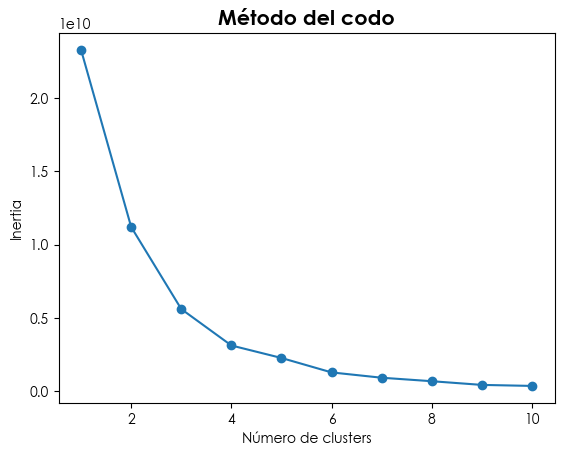

In [64]:
#Gráfica de codo para determinar número de clusters
plt.rcParams["font.family"] = "Century Gothic"
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(colonias[variables])
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Método del codo", fontsize=15,fontweight="bold")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia")


In [65]:
# Clusterizar colonias
kmeans=KMeans(n_clusters=3, random_state=0)
colonias["cluster"]=kmeans.fit_predict(colonias[variables])
colonias

C:\Users\claud\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


objectid     cve_col  id_col                  colonia     cp cve_ent  \
24557     34245  15061_0001   34245               Tlaquilpan  43830      15   
28961     39771  15002_0015   39771               Las Brisas  55883      15   
28963     39773  15002_0017   39773              Las Huertas  55870      15   
28973     39787  15002_0027   39787      San Marcos Nepantla  55887      15   
28983     39828  15005_0002   39828       Barrio La Cabecera  50904      15   
...         ...         ...     ...                      ...    ...     ...   
72526    102008  15087_0017  102008       San Lorenzo Oyamel  50810      15   
72527    102009  15088_0018  102009     Capilla de Guadalupe  52400      15   
72529    102011  15088_0020  102011  Capilla de Los Remedios  52400      15   
72553    102038  15090_0042  102038              El Porvenir  52360      15   
72638    102170  15118_0054  102170            Independencia  51900      15   

      nom_ent  mun cve_mun             nom_mun  ...      ovhac     ovsref  \
24557  México  061   15061          Nopaltepec  ...  27.428021  11.270018   
28961  México  002   15002             Acolman  ...  38.831662  12.912990   
28963  México  002   15002             Acolman  ...  29.326109  18.609511   
28973  México  002   15002             Acolman  ...  29.531867  18.734393   
28983  México  005   15005  Almoloya de Juárez  ...  32.143708  28.424021   
...       ...  ...     ...                 ...  ...        ...        ...   
72526  México  087   15087             Temoaya  ...  35.158078  30.628388   
72527  México  088   15088          Tenancingo  ...  41.152757  28.243347   
72529  México  088   15088          Tenancingo  ...  34.029371  20.797581   
72553  México  090   15090   Tenango del Valle  ...  32.815765  33.741415   
72638  México  118   15118        Zinacantepec  ...  34.572686  33.681827   

          ovsint     ovscel     im_2020  gm_2020  imn_2020  \
24557  82.909879   8.487767  147.134550     Alto  0.938071   
28961  50.544574   5.865436  144.780492     Alto  0.923063   
28963  60.946585   9.345662  144.452433     Alto  0.920971   
28973  62.368838   9.194681  144.702197     Alto  0.922563   
28983  75.337448  13.880570  144.470784     Alto  0.921088   
...          ...        ...         ...      ...       ...   
72526  73.253258  20.374982  144.175126     Alto  0.919203   
72527  56.928273  11.187921  144.454657     Alto  0.920985   
72529  44.951878  12.221795  146.067450     Alto  0.931268   
72553  78.351745  13.556285  145.381774     Alto  0.926896   
72638  71.420523   9.413256  144.704618     Alto  0.922579   

                      clasif  \
24557                 Barrio   
28961                Colonia   
28963                Colonia   
28973                 Pueblo   
28983                 Pueblo   
...                      ...   
72526  Conjunto habitacional   
72527                 Barrio   
72529                 Barrio   
72553                Colonia   
72638                Colonia   

                                                geometry  cluster  
24557  POLYGON ((2847862.690 876830.402, 2847751.959 ...        0  
28961  POLYGON ((2815822.367 847458.590, 2815821.351 ...        1  
28963  POLYGON ((2820164.907 854851.228, 2820152.097 ...        0  
28973  POLYGON ((2822553.845 857055.110, 2822061.071 ...        0  
28983  POLYGON ((2735640.287 820835.317, 2735779.949 ...        1  
...                                                  ...      ...  
72526  POLYGON ((2752864.901 829675.420, 2753493.817 ...        1  
72527  POLYGON ((2753144.058 776736.558, 2753048.341 ...        0  
72529  POLYGON ((2752735.474 777022.072, 2752792.686 ...        0  
72553  POLYGON ((2747354.534 793528.708, 2747381.532 ...        0  
72638  POLYGON ((2734527.591 807473.472, 2734511.714 ...        0  

[811 rows x 33 columns]

In [66]:
#Contar cuántas colonias hay en cada cluster
colonias["cluster"].value_counts()

cluster
0    698
1    110
2      3
Name: count, dtype: int64

In [67]:
#Obtener cluster de San Carlos Cantera
cluster_scc=colonias[colonias["colonia"]=="San Carlos Cantera"]["cluster"].values[0]
cluster_scc

0

In [68]:
#Filtrar cluster cero
cluster_objetivo=colonias[colonias["cluster"]==cluster_scc]
#Dejar solo aquellas con población una desviación estándar arriba y abajo de San Carlos Cantera
cluster_objetivo=cluster_objetivo[(cluster_objetivo["pobtot"]>sancarloscantera["pobtot"].sum()-cluster_objetivo["pobtot"].std()) & (cluster_objetivo["pobtot"]<sancarloscantera["pobtot"].sum()+cluster_objetivo["pobtot"].std())]

#Contar cuántas colonias hay en el cluster objetivo
cluster_objetivo["cluster"].value_counts()

cluster
0    209
Name: count, dtype: int64

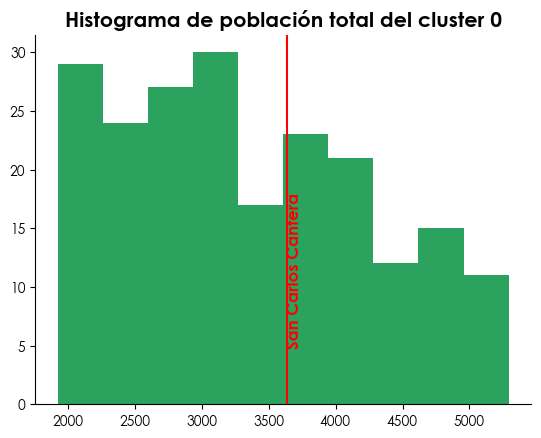

In [69]:
#Histograma de población total del cluster 0
plt.hist(cluster_objetivo["pobtot"],color="#2ca25f")
plt.title("Histograma de población total del cluster 0", fontsize=15,fontweight="bold")
#Línea vertical de San Carlos Cantera
plt.axvline(sancarloscantera["pobtot"].values[0], color="red")
plt.text(sancarloscantera["pobtot"].values[0], 5, "San Carlos Cantera", rotation=90,color="red", fontsize=12, fontweight="bold")
#Eliminar eje derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

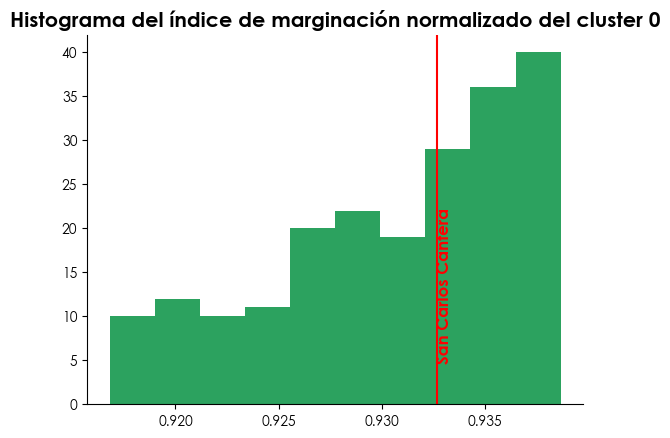

In [70]:
#Histograma del índice de marginación normalizado del cluster 0
plt.hist(cluster_objetivo["imn_2020"], color="#2ca25f")
plt.title("Histograma del índice de marginación normalizado del cluster 0", fontsize=15,fontweight="bold")
#Línea vertical de San Carlos Cantera
plt.axvline(sancarloscantera["imn_2020"].values[0], color="red")
plt.text(sancarloscantera["imn_2020"].values[0], 5, "San Carlos Cantera", rotation=90, color="red",fontsize=12, fontweight="bold")
#Eliminar eje derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [71]:
cluster_objetivo

objectid     cve_col  id_col              colonia     cp cve_ent  \
28973     39787  15002_0027   39787  San Marcos Nepantla  55887      15   
28995     39876  15005_0014   39876            San Pedro  50900      15   
29004     39901  15009_0002   39901               Atenco  56900      15   
29015     39914  15009_0012   39914     San Pedro Nexapa  56960      15   
29052     39968  15011_0023   39968             Zapotlan  56300      15   
...         ...         ...     ...                  ...    ...     ...   
33393     45581  15122_0003   45581           Americas I  56610      15   
33394     45582  15122_0004   45582          Americas Ii  56610      15   
33399     45587  15122_0009   45587    Cerro del Marques  56614      15   
72303    101603  15031_0118  101603         Acuitlapilco  56364      15   
72487    101936  15070_0075  101936       Loma Encantada  56495      15   

      nom_ent  mun cve_mun                      nom_mun  ...      ovhac  \
28973  México  002   15002                      Acolman  ...  29.531867   
28995  México  005   15005           Almoloya de Juárez  ...  26.274843   
29004  México  009   15009                    Amecameca  ...  32.942698   
29015  México  009   15009                    Amecameca  ...  39.860685   
29052  México  011   15011                       Atenco  ...  42.012311   
...       ...  ...     ...                          ...  ...        ...   
33393  México  122   15122  Valle de Chalco Solidaridad  ...  37.422750   
33394  México  122   15122  Valle de Chalco Solidaridad  ...  41.914943   
33399  México  122   15122  Valle de Chalco Solidaridad  ...  44.473414   
72303  México  031   15031                 Chimalhuacán  ...  42.381249   
72487  México  070   15070                       La Paz  ...  45.422935   

          ovsref     ovsint     ovscel     im_2020  gm_2020  imn_2020  \
28973  18.734393  62.368838   9.194681  144.702197     Alto  0.922563   
28995  23.385628  64.997550   9.672183  145.985244     Alto  0.930744   
29004  19.465398  51.790516  15.909504  147.027376     Alto  0.937388   
29015  37.531151  76.631714  14.795693  145.036468     Alto  0.924695   
29052  22.529938  47.805255  11.059931  146.650614     Alto  0.934986   
...          ...        ...        ...         ...      ...       ...   
33393  13.073201  35.846398   9.819975  147.032488     Alto  0.937420   
33394  19.010309  35.128181   8.823797  145.509737     Alto  0.927712   
33399  20.480352  47.456602  12.013728  145.302403     Alto  0.926390   
72303  16.334265  44.878187  10.598612  145.646012     Alto  0.928581   
72487  21.440184  47.638243   9.644225  144.540675     Alto  0.921534   

                clasif                                           geometry  \
28973           Pueblo  POLYGON ((2822553.845 857055.110, 2822061.071 ...   
28995           Barrio  POLYGON ((2733721.626 822530.805, 2733727.057 ...   
29004           Barrio  POLYGON ((2839204.938 795201.298, 2839303.422 ...   
29015           Pueblo  POLYGON ((2842903.494 791630.692, 2842937.274 ...   
29052           Pueblo  POLYGON ((2824299.907 841549.321, 2824289.700 ...   
...                ...                                                ...   
33393          Colonia  POLYGON ((2818927.192 813541.452, 2818963.145 ...   
33394          Colonia  POLYGON ((2819050.555 813020.130, 2819074.143 ...   
33399          Colonia  POLYGON ((2822098.836 811265.028, 2822075.392 ...   
72303          Colonia  POLYGON ((2821247.250 830195.646, 2821248.375 ...   
72487  Fraccionamiento  POLYGON ((2818197.752 819859.928, 2818339.614 ...   

       cluster  
28973        0  
28995        0  
29004        0  
29015        0  
29052        0  
...        ...  
33393        0  
33394        0  
33399        0  
72303        0  
72487        0  

[209 rows x 33 columns]

#### Mapa de colonias con características similares a San Carlos Cantera

In [72]:
#Leer capa de municipios
mun=gpd.read_file("data/conjunto_de_datos/15mun.shp")

In [73]:
# Función para colores
def style_function(feature):
    if feature['properties']['colonia'] == 'San Carlos Cantera':
        return {'color': 'red'}
    else:
        return {'color': 'blue'} 

In [80]:
m = folium.Map(location=[19.5814982, -99.0611739], zoom_start=12, tiles=None, control_scale=True)

# CartoDB
folium.TileLayer(
    tiles='cartodbpositron',
    attr='CartoDB',
    name='CartoDB',  # Custom name for the layer control
    overlay=False,
    control=True
).add_to(m)

# Add Google Hybrid layer
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Hybrid',
    overlay=False,
    control=True
).add_to(m)

# Capa municipios
folium.GeoJson(
    mun,
    name="Municipios",
    style_function=lambda x: {
        'color': 'black',  
        'weight': 1.5,  
        'fillColor': 'transparent',  
        'fillOpacity': 0 
    }
).add_to(m)

# Custom tooltip with Century Gothic font
tooltip = folium.GeoJsonTooltip(
    fields=["colonia", "nom_mun", "pobtot", "imn_2020", "gm_2020"],
    aliases=["Colonia", "Municipio", "Población total", "Índice de marginación normalizado", "Grado de marginación"],
    style=("background-color: white; color: black; font-family: 'Century Gothic'; font-size: 12px; padding: 5px;")
)

# Capa colonias
folium.GeoJson(
    cluster_objetivo,
    name="Colonias",
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

#Añadir manzanas de San Carlos Cantera
folium.GeoJson(sancarlosmza,
               name="Manzanas",
               style_function=lambda x: {
        'color': 'purple',  # Border color
        'weight': 1.5,  # Border thickness
        'fillColor': 'transparent',  # Transparent fill color
        'fillOpacity': 0  # Fully transparent fill
    },
               tooltip=folium.GeoJsonTooltip(fields=["cvegeo"], aliases=["Clave de la manzana: "], style=("background-color: white; color: black; font-family: 'Century Gothic'; font-size: 12px; padding: 5px;"))
               ).add_to(m)

folium.LayerControl().add_to(m)

# Salvar mapa y mostrar
m.save("colonias_similares_sancarloscantera.html")

m
